# **Depth extension and general training experiments**

In this notebook, we extend our heatmap-based keypoint regression to leverage both RGB and depth inputs by introducing a two-stage cross-fusion module that learns to merge complementary features.

The model uses parallel ResNet-18 encoders for RGB and depth, fuses their 256×32×32 feature maps, and applies a three-stage decoder to produce 50×64×64 heatmaps.

It accepts paired 256×256 RGB cropped images and aligned depth maps as input.

We carry out general training experiments to compare different activation functions and learning-rate schedulers.

## **Importing required libraries and modules**

In [1]:
import torchvision.models as models
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import random
import json
from collections import defaultdict
from torch.utils.data import Dataset
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import lr_scheduler
import numpy as np
import torch.nn.functional as F
from torchvision import models, transforms
import torch.optim as optim
import argparse
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.lr_scheduler import PolynomialLR
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Model definition**

This section defines the **CrossFuNet** architecture, which fuses complementary RGB and depth information for keypoint heatmap regression. Two parallel ResNet-18 encoders extract 256-channel feature maps from the 256×256 RGB and depth inputs.

A **TwoStageFusion** module then merges these features via residual cross‐sums and additional residual blocks, producing a 512-channel fused representation.

Finally, a **HeatmapHead** applies two convolutional layers followed by a final 1×1 convolution, then upsamples the output using bilinear interpolation to produce a 50-channel 64×64 tensor.

In [3]:
# ------------------ ResidualBlock ------------------
class ResidualBlock(nn.Module):
    def __init__(self, channels, activation='relu'):
        super().__init__()
        act_func = activation_map[activation]
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.act = act_func(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x
        out = self.act(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.act(out)

# ------------------ TwoStageFusion ------------------
class TwoStageFusion(nn.Module):
    def __init__(self, channels, activation='relu'):
        super().__init__()
        self.rb1_rgb   = ResidualBlock(channels, activation)
        self.rb1_depth = ResidualBlock(channels, activation)
        self.rb2_rgb   = ResidualBlock(channels, activation)
        self.rb2_depth = ResidualBlock(channels, activation)

    def forward(self, x_rgb, x_depth):

        fbc = self.rb1_rgb(x_rgb)
        fbd = self.rb1_depth(x_depth)

        rgb_in =  fbc + x_depth
        dpt_in =  fbd + x_rgb

        out_rgb = self.rb2_rgb(rgb_in)
        out_dpt = self.rb2_depth(dpt_in)

        return torch.cat([out_rgb, out_dpt], dim=1)  # [B, 2*channels, H, W]

class HeatmapHead(nn.Module):
    def __init__(self, activation, num_keypoints, in_channels):
        super().__init__()
        act_cls = activation_map[activation]

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            act_cls(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            act_cls(inplace=True),

            nn.Conv2d(256, num_keypoints, kernel_size=1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = F.interpolate(x, size=(64, 64), mode='bilinear', align_corners=False)
        return x


class CrossFuNet(nn.Module):
    def __init__(self, num_keypoints=50, activation='relu'):
        super().__init__()

        base_rgb = models.resnet18(pretrained=True)
        base_depth = models.resnet18(pretrained=True)

        # Prevent downsampling in layer3 to preserve 32x32 spatial size
        base_rgb.layer3[0].conv1.stride = (1, 1)
        base_rgb.layer3[0].downsample[0].stride = (1, 1)
        base_depth.layer3[0].conv1.stride = (1, 1)
        base_depth.layer3[0].downsample[0].stride = (1, 1)

        self.rgb_encoder   = nn.Sequential(*list(base_rgb.children())[:7])  # up to layer3 (32x32x256)
        self.depth_encoder = nn.Sequential(*list(base_depth.children())[:7])

        self.depth_encoder[0] = nn.Conv2d(1, 64, 7, 2, 3, bias=False)

        self.cross_fusion = TwoStageFusion(256, activation)
        self.decoder = HeatmapHead(activation, num_keypoints=num_keypoints, in_channels=512)  # after fusion: 2*256 = 512

    def forward(self, rgb, depth):
        feat_rgb   = self.rgb_encoder(rgb)
        feat_depth = self.depth_encoder(depth)
        assert feat_rgb.shape[1:] == feat_depth.shape[1:], f"RGB vs Depth feature mismatch: {feat_rgb.shape} vs {feat_depth.shape}"
        fused = self.cross_fusion(feat_rgb, feat_depth)
        assert fused.shape[-2:] == (32,32) and fused.shape[1] == 512, f"Fusion output wrong: {fused.shape}"
        heatmaps = self.decoder(fused)
        assert heatmaps.shape[-2:] == (64,64), f"Head output wrong: {heatmaps.shape}"
        return heatmaps

## **Focal loss function**

As in the baseline model, we employ focal loss as our loss function.










In [4]:
# Definition of a loss function
import torch.nn.functional as F

def focal_heatmap_loss(pred, gt, alpha=2.0, gamma=4.0, eps=1e-6):

    # 1) Turn output into confidence
    p = torch.sigmoid(pred)

    # 2) Positive term: region where the keypoint is
    pos = - alpha * (1 - p)**gamma * gt * torch.log(p + eps)

    # 3) Negative term: background
    neg = - (1 - gt) * torch.log(1 - p + eps)

    return (pos + neg).mean()

## **Defition of the dataset class**

In [6]:
class KeypointHeatmapDataset(Dataset):
    def __init__(self, img_dir, hm_dir, depth_dir, img_ext=".png", depth_ext=".png", hm_ext=".pt"):
        self.img_dir   = img_dir
        self.depth_dir = depth_dir
        self.hm_dir    = hm_dir
        self.img_ext   = img_ext
        self.depth_ext = depth_ext
        self.hm_ext    = hm_ext

        all_names = sorted([
            os.path.splitext(f)[0]
            for f in os.listdir(self.img_dir)
            if f.endswith(self.img_ext)
        ])

        groups = defaultdict(list)
        for name in all_names:
            obj_id = name.split("_")[0]
            groups[obj_id].append(name)

        total     = len(all_names)
        ratio     = 1
        target_n  = int(total * ratio)

        floors, remainders = {}, {}
        for obj_id, lst in groups.items():
            raw        = len(lst) * ratio
            fl         = int(raw)
            floors[obj_id]    = fl
            remainders[obj_id] = raw - fl

        sum_floor = sum(floors.values())
        leftover  = target_n - sum_floor
        for obj_id in sorted(remainders, key=lambda x: remainders[x], reverse=True)[:leftover]:
            floors[obj_id] += 1

        chosen = []
        random.seed(42)
        for obj_id, lst in groups.items():
            k = floors[obj_id]
            chosen.extend(random.sample(lst, k))

        self.basenames = sorted(chosen)

        # Data normalization
        self.transform_img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225]
            ),
        ])

        img_basenames = {
            os.path.splitext(f)[0]
            for f in os.listdir(self.img_dir)
            if f.endswith(self.img_ext)
        }
        hm_basenames = {
            os.path.splitext(f)[0]
            for f in os.listdir(self.hm_dir)
            if f.endswith(self.hm_ext)
        }

    def __len__(self):
        return len(self.basenames)

    def __getitem__(self, idx):
        name = self.basenames[idx]

        # 1) RGB image
        img_path = os.path.join(self.img_dir, name + self.img_ext)
        img = Image.open(img_path).convert("RGB")
        img = self.transform_img(img)  # [3, H, W]

        # 2) Depth image
        dpt_path = os.path.join(self.depth_dir, name + self.depth_ext)
        depth = Image.open(dpt_path)
        depth_np = np.array(depth).astype(np.float32)  # [H, W], u mm
        depth_np = (depth_np - 500.0) / 1000.0
        depth_np = np.clip(depth_np, 0.0, 1.0)
        depth = torch.from_numpy(depth_np).unsqueeze(0)  # [1, H, W]

        # 3) Heatmap
        hm_path = os.path.join(self.hm_dir, name + self.hm_ext)
        heatmaps = torch.load(hm_path)  # [K, h, w]

        return img, depth, heatmaps


Supporting function to fetch the directory path for keypoint heatmaps produced by either FPS or CPS sampling.

In [7]:
def get_hm_folder(hm_type: str) -> str:
    base = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/heatmaps_sigma_2"
    if hm_type == 'fps':
        return f"{base}/heatmaps_fps"
    elif hm_type == 'cps':
        return f"{base}/heatmaps_cps"
    else:
        raise ValueError(f"Unknown hm_type: {hm_type}")




*   make_dataset - selects the FPS or CPS heatmap folder and returns a paired image–heatmap dataset
*   make_loaders -  splits that dataset 80/20 (train/val) with a fixed seed and wraps each in a DataLoader



In [8]:
from torch.utils.data import DataLoader

img_folder = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/cropped_resized_data"
depth_folder = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/cropped_resized_depth_data"


def make_dataset(hm_type):
    hm_folder = get_hm_folder(hm_type)
    return KeypointHeatmapDataset(
        img_dir=img_folder,
        hm_dir=hm_folder,
        depth_dir=depth_folder,
        img_ext=".png",
        hm_ext=".pt"
    )

def make_loaders(dataset):
    n_total = len(dataset)
    n_train = int(0.8 * n_total)
    n_val = n_total - n_train
    train_ds, val_ds = random_split(
        dataset,
        [n_train, n_val],
        generator=torch.Generator().manual_seed(8)
    )
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=4, pin_memory=False)
    val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=4, pin_memory=False)
    return train_loader, val_loader

## **Definition of parameter structures**

This part defines simple name‐to‐class mappings for activation functions (relu, silu, mish) and two learning‐rate schedulers (onecycle, polynomial), so we can switch them by string key during experiments

In [9]:
activation_map = {
    'relu': nn.ReLU,
    'silu': nn.SiLU,
    'mish': nn.Mish,
}

base_lr    = 1e-4
max_lr     = 5e-4
EPOCHS = 30

scheduler_map = {
# One cycle learning rate: max_lr set to initial lr
    'onecycle': lambda optimizer, num_epochs, loader: OneCycleLR(
        optimizer,
        max_lr=max_lr,
        epochs=EPOCHS,
        steps_per_epoch=len(loader),
        pct_start=0.1,           # 10% warm-up
        anneal_strategy='cos',   # cosine decay
        div_factor=10.0,         # max_lr = base_lr * div_factor
        final_div_factor=1e4
    ),
# Polynomial learning rate decay with power=2
    'polynomial': lambda optimizer, num_epochs, loader: PolynomialLR(
        optimizer,
        total_iters = num_epochs * len(loader),
        power=2.0,
        last_epoch=-1
    ),
}

## **Utility functions**

This section provides utility functions for post‐processing and visualizing model outputs:

*   *get_keypoints_from_heatmaps* and *get_all_keypoints* locate the peak value in each heatmap channel to compute (x, y) keypoint coordinates—either in heatmap space or scaled back to the original image resolution
*   *denormalize_rgb* reverses ImageNet normalization on a [3, H, W] tensor to produce a [H, W, 3] numpy image in [0, 1]
*   *visualize_prediction* then overlays ground‐truth (lime circles) and predicted (red crosses) keypoints on the RGB image for qualitative inspection.



In [10]:
# --- 1. Extraction of coordinates from heatmaps ---
def get_keypoints_from_heatmaps(hm_np):
    """
    Input: heatmap numpy array [K, H, W]
    Output: keypoints [K, 2] with (x, y) in heatmap space
    """
    K, H, W = hm_np.shape
    coords = []
    for i in range(K):
        yx = np.unravel_index(np.argmax(hm_np[i]), (H, W))
        coords.append((yx[1], yx[0]))  # (x, y)
    return np.array(coords)


# --- 2. Denormalization of the RGB image ---
def denormalize_rgb(img_tensor):
    """
    img_tensor: [3, H, W] normalized image
    returns: numpy image [H, W, 3] in [0,1]
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img_tensor * std + mean
    img = img.permute(1, 2, 0).cpu().numpy()
    return np.clip(img, 0, 1)


# --- 3. Visualize RGB image with GT and predictions ---
def visualize_prediction(rgb_tensor, gt_hm, pred_hm, scale=4):
    """
    rgb_tensor: [3, 256, 256]
    gt_hm: [K, 64, 64]
    pred_hm: [K, 64, 64]
    """
    if isinstance(gt_hm, torch.Tensor): gt_hm = gt_hm.cpu().numpy()
    if isinstance(pred_hm, torch.Tensor): pred_hm = pred_hm.cpu().numpy()

    gt_pts = get_keypoints_from_heatmaps(gt_hm) * scale
    pr_pts = get_keypoints_from_heatmaps(pred_hm) * scale
    img_np = denormalize_rgb(rgb_tensor)

    plt.figure(figsize=(5, 5))
    plt.imshow(img_np)
    plt.scatter(gt_pts[:, 0], gt_pts[:, 1], c='lime', marker='o', label='GT')
    plt.scatter(pr_pts[:, 0], pr_pts[:, 1], c='red', marker='x', label='Pred')
    plt.title("Predicted vs. GT keypoints")
    plt.axis('off')
    plt.legend(loc='lower right')
    plt.show()

def get_all_keypoints(preds, hmap_size=64, img_size=256):
    B, K, H, W = preds.shape
    scale = img_size / hmap_size
    offset = scale / 2
    preds = preds.cpu()
    all_results = []

    for b in range(B):
        heatmaps = preds[b]  # [K, H, W]
        pts = []
        for idx in range(K):
            hm = heatmaps[idx]
            flat = hm.view(-1)
            pos = flat.argmax().item()
            y, x = divmod(pos, W)
            x = x * scale + offset
            y = y * scale + offset
            pts.append([float(x), float(y)])  # JSON-friendly format
        all_results.append(pts)

    return all_results

## **Training definition**

This function performs one full epoch of training (forward pass, loss computation, backpropagation, optimizer step, scheduler), validation (loss evaluation) and checkpointing (saving the model whenever validation loss improves).

In [11]:
def train_one_epoch(model, train_loader, val_loader, optimizer, criterion, device, epoch, best_val_loss, save_path, scheduler=None):
    model.train()
    running_loss = 0.0
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)
    for rgb, depth, heatmaps_gt in train_loop:
        rgb, depth, heatmaps_gt = rgb.to(device), depth.to(device), heatmaps_gt.to(device)

        optimizer.zero_grad()
        heatmaps_pred = model(rgb, depth)
        loss = criterion(heatmaps_pred, heatmaps_gt)

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * rgb.size(0)
        train_loop.set_postfix(loss=loss.item())
    avg_train_loss = running_loss / len(train_loader.dataset)

    if scheduler is not None:
        scheduler.step()

    model.eval()
    val_loss = 0.0
    val_loop = tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False)
    with torch.no_grad():
        for rgb, depth, heatmaps_gt in val_loop:
            rgb, depth, heatmaps_gt = rgb.to(device), depth.to(device), heatmaps_gt.to(device)
            heatmaps_pred = model(rgb, depth)
            loss = criterion(heatmaps_pred, heatmaps_gt)
            val_loss += loss.item() * rgb.size(0)
            val_loop.set_postfix(loss=loss.item())
    avg_val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print(f" Saved best model ({save_path}) at epoch {epoch} (val_loss={avg_val_loss:.4f})")
    return avg_train_loss, avg_val_loss, best_val_loss

Device configuration

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
else:
    print("CPU")

CPU


Training the model - key training parameters:

* Epochs: 30
*   Optimizer: Adam, learning rate = 1e-4
* Loss: focal heatmap loss

In [13]:
EPOCHS = 30
SAVE_TEMPLATE = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/resnet/extended_{activation}_model.pth"

In [ ]:
print(f"\n === Training the extended model ===")
scheduler = None
# a) Dataset + loaders
ds = make_dataset('fps')
train_loader, val_loader = make_loaders(ds)

# b) Model, optim, loss
model = CrossFuNet(num_keypoints=50, activation='relu').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = focal_heatmap_loss
best_val = float('inf')
save_path = SAVE_TEMPLATE.format(activation='relu', hm_type='fps')

# c) Epochs
for epoch in range(1, EPOCHS + 1):
    train_loss, val_loss, best_val = train_one_epoch(
        model, train_loader, val_loader,
        optimizer, criterion, device,
        epoch, best_val, save_path, scheduler
    )


 === Training the extended model ===


This code loads the trained CrossFuNet model (ReLU, no scheduler) in eval mode, runs it over the validation set to extract [x,y] keypoint coordinates from the predicted heatmaps, and collects these per image basename. It then creates the output directory if needed and writes the image-to-keypoints mapping to a JSON file.

In [14]:
activation = 'relu'
model = CrossFuNet(num_keypoints=50, activation=activation).to(device)
SAVE_PATH = f"/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/resnet/extended_{activation}_model.pth"
model.load_state_dict(torch.load(SAVE_PATH, map_location=device))
model.eval()

# Dataset reference info
subset     = val_loader.dataset            # Subset
orig_ds    = subset.dataset                # Original KeypointHeatmapDataset
indices    = subset.indices                # Map subset index to global
batch_size = val_loader.batch_size

# Dict for predictions
predictions = {}

# Loop through all validation examples
for batch_i, (rgb_imgs, dpt_imgs, _) in enumerate(val_loader):
    rgb_imgs = rgb_imgs.to(device)
    dpt_imgs = dpt_imgs.to(device)

    with torch.no_grad():
        preds = model(rgb_imgs, dpt_imgs).cpu()

    batch_keypoints = get_all_keypoints(preds)

    for i, pts in enumerate(batch_keypoints):
        global_idx = indices[batch_i * batch_size + i]
        img_id = orig_ds.basenames[global_idx]
        predictions[img_id] = pts

# Export as JSON
out_dir = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/predicted_key_points"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, f"extended_{activation}_predictions.json")

with open(out_path, "w") as f:
    json.dump(predictions, f, indent=2, sort_keys=True)

print(f"Saved {len(predictions)} keypoint predictions to {out_path}")

Saved 2843 keypoint predictions to /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/predicted_key_points/extended_relu_predictions.json


Comparing the predicted keypoints with the ground-truth on 3 random samples

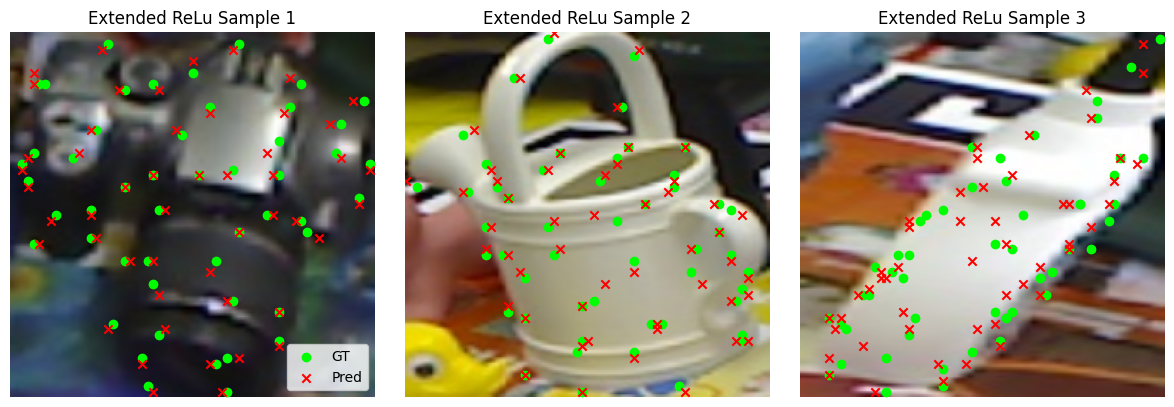

In [ ]:
activation = 'relu'
model = CrossFuNet(num_keypoints=50, activation=activation).to(device)
save_path = f"/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/resnet/extended_{activation}_model.pth"
model.load_state_dict(torch.load(save_path, map_location=device))
model.eval()

# 2) Run one batch from val_loader
rgb_batch, depth_batch, gt_hm_batch = next(iter(val_loader))
with torch.no_grad():
    pred_hm_batch = model(rgb_batch.to(device), depth_batch.to(device)).cpu()

# 3) Plot the first 3 samples

    n = min(3, rgb_batch.size(0))
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
    if n == 1:
      axes = [axes]

    for i in range(n):
        ax = axes[i]
        # Denormalize and scale keypoints
        img_np = denormalize_rgb(rgb_batch[i])
        gt_pts = get_keypoints_from_heatmaps(gt_hm_batch[i].cpu().numpy()) * 4
        pr_pts = get_keypoints_from_heatmaps(pred_hm_batch[i].numpy()) * 4

        ax.imshow(img_np)
        ax.scatter(gt_pts[:, 0], gt_pts[:, 1], c='lime',  marker='o', label='GT')
        ax.scatter(pr_pts[:, 0], pr_pts[:, 1], c='red',   marker='x', label='Pred')
        ax.set_title(f"Extended ReLu Sample {i+1}")
        ax.axis('off')
        if i == 0:
            ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()


# General training experiments

In this section, we conduct general training experiments to assess how different activation functions and learning‐rate schedulers  affect CrossFuNet’s performance. Each configuration is trained on the same RGB–depth data split with identical hyperparameters, and we record the training and validation losses to compare their best validation metrics. All the experiments are done on a model that is using FPS keypoint selection method


### Activation function experiments

We will extend our baseline by replacing the ReLU activation with SiLU and Mish in separate experiments.

In [15]:
EPOCHS = 30
SAVE_TEMPLATE = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/resnet/extended_{activation}_model.pth"

In [ ]:
for activation in ['silu', 'mish']:
    print(f"General training experiment: activation function = {activation}")
    scheduler = None

    # a) Dataset + loaders
    hm = 'fps'
    ds = make_dataset(hm)
    train_loader, val_loader = make_loaders(ds)

    # b) Model, optim, loss
    model = CrossFuNet(num_keypoints=50, activation=activation).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = focal_heatmap_loss
    best_val = float('inf')
    save_path = SAVE_TEMPLATE.format(activation=activation, hm_type=hm)

    # c) epohs
    for epoch in range(1, EPOCHS + 1):
        train_loss, val_loss, best_val = train_one_epoch(
            model, train_loader, val_loader,
            optimizer, criterion, device,
            epoch, best_val, save_path, scheduler = None

        )

General training experiment: activation function = silu
General training experiment: activation function = mish


In [16]:
for activation in ['silu', 'mish']:
    # a) Init model and load weights (no scheduler, fps)
    model = CrossFuNet(num_keypoints=50, activation=activation).to(device)
    SAVE_PATH = f"/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/resnet/extended_{activation}_model.pth"
    model.load_state_dict(torch.load(SAVE_PATH, map_location=device))
    model.eval()

    # b) Dataset reference info from val_loader
    subset     = val_loader.dataset        # Subset from make_loaders
    orig_ds    = subset.dataset            # Original KeypointHeatmapDataset
    indices    = subset.indices            # Map subset index to global
    batch_size = val_loader.batch_size

    # c) Collect predictions
    predictions = {}
    for batch_i, (rgb_imgs, dpt_imgs, _) in enumerate(val_loader):
        rgb_imgs = rgb_imgs.to(device)
        dpt_imgs = dpt_imgs.to(device)
        with torch.no_grad():
            preds = model(rgb_imgs, dpt_imgs).cpu()
        batch_keypoints = get_all_keypoints(preds)
        for i, pts in enumerate(batch_keypoints):
            global_idx = indices[batch_i * batch_size + i]
            img_id     = orig_ds.basenames[global_idx]
            predictions[img_id] = pts

    # d) Export to JSON
    out_dir = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/predicted_key_points"
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"extended_{activation}_predictions.json")
    with open(out_path, "w") as f:
        json.dump(predictions, f, indent=2, sort_keys=True)
    print(f"Saved {len(predictions)} keypoint predictions to {out_path}")

Saved 2843 keypoint predictions to /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/predicted_key_points/extended_silu_predictions.json
Saved 2843 keypoint predictions to /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/predicted_key_points/extended_mish_predictions.json


Comparing the predicted keypoints with the ground-truth


=== Activation: silu ===




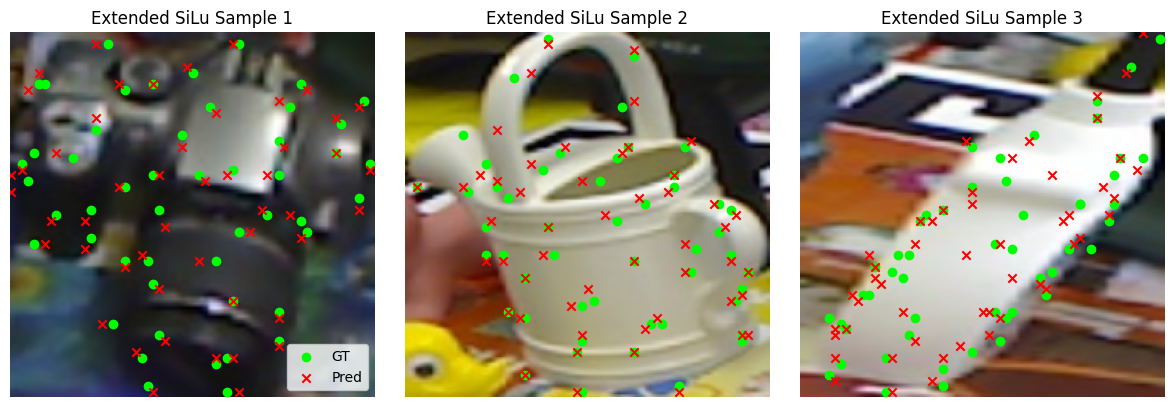





=== Activation: mish ===




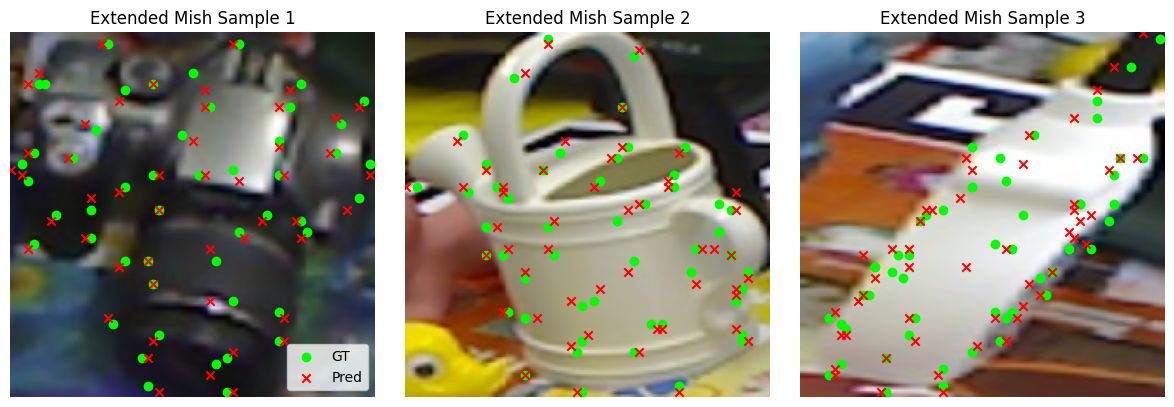

In [ ]:
activations = ['silu', 'mish']

for activation in activations:
    print(f"\n=== Activation: {activation} ===\n\n")

    # 1) Load the trained model
    model = CrossFuNet(num_keypoints=50, activation=activation).to(device)
    save_path = f"/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/resnet/extended_{activation}_model.pth"
    model.load_state_dict(torch.load(save_path, map_location=device))
    model.eval()

    # 2) Run one batch from val_loader
    rgb_batch, depth_batch, gt_hm_batch = next(iter(val_loader))
    with torch.no_grad():
        pred_hm_batch = model(rgb_batch.to(device), depth_batch.to(device)).cpu()

    # 3) Plot the first 3 samples

    n = min(3, rgb_batch.size(0))
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))

    if n == 1:
      axes = [axes]

    # Set the title of the plot
    display_names = {
    'silu': 'SiLu',
    'mish': 'Mish'
    }
    title_name = display_names.get(activation, activation)


    for i in range(n):
        ax = axes[i]
        # Denormalize and scale keypoints
        img_np = denormalize_rgb(rgb_batch[i])
        gt_pts = get_keypoints_from_heatmaps(gt_hm_batch[i].cpu().numpy()) * 4
        pr_pts = get_keypoints_from_heatmaps(pred_hm_batch[i].numpy()) * 4

        ax.imshow(img_np)
        ax.scatter(gt_pts[:, 0], gt_pts[:, 1], c='lime',  marker='o', label='GT')
        ax.scatter(pr_pts[:, 0], pr_pts[:, 1], c='red',   marker='x', label='Pred')
        ax.set_title(f"Extended {title_name} Sample {i+1}")
        ax.axis('off')
        if i == 0:
            ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

    print("\n\n")



### Scheduler experiments

For the scheduler experiments, we will compare OneCycleLR (with cosine annealing) and PolynomialLR (quadratic decay) under identical training conditions, testing them with all activation functions that we used

In [17]:
EPOCHS = 30
SAVE_TEMPLATE = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/resnet/extended_{activation}_{scheduler_name}_model.pth"

In [18]:
suffix_map = {
    'onecycle': 'cos',
    'polynomial': 'poly'
}

for scheduler_name in ['onecycle', 'polynomial']:
  for activation in ['relu', 'silu', 'mish']:
      hm = 'fps'
      ds = make_dataset(hm)
      train_loader, val_loader = make_loaders(ds)
      print(f"Scheduler experiment: scheduler={scheduler_name}, activation={activation}")

      model     = CrossFuNet(num_keypoints=50, activation=activation).to(device)
      optimizer = torch.optim.Adam(model.parameters(), lr=base_lr)
      criterion = focal_heatmap_loss
      best_val  = float('inf')
      suffix = suffix_map[scheduler_name]
      save_path = (
          f"/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/resnet/extended_{activation}_{suffix}_model.pth"
      )
      scheduler = scheduler_map[scheduler_name](optimizer, EPOCHS, train_loader)

      for epoch in range(1, EPOCHS + 1):
          train_loss, val_loss, best_val = train_one_epoch(
              model, train_loader, val_loader,
              optimizer, criterion, device,
              epoch, best_val, save_path, scheduler
          )

Scheduler experiment: scheduler=onecycle, activation=relu
Scheduler experiment: scheduler=onecycle, activation=silu
Scheduler experiment: scheduler=onecycle, activation=mish
Scheduler experiment: scheduler=polynomial, activation=relu
Scheduler experiment: scheduler=polynomial, activation=silu
Scheduler experiment: scheduler=polynomial, activation=mish


In [ ]:
for scheduler_name in ['onecycle', 'polynomial']:
  for activation in ['silu', 'mish']:
    model = CrossFuNet(num_keypoints=50, activation=activation).to(device)

    if scheduler_name == 'onecycle':
      SAVE_PATH = f"/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/resnet/extended_{activation}_cos_model.pth"
    else:
      SAVE_PATH = f"/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/resnet/extended_{activation}_poly_model.pth"

    model.load_state_dict(torch.load(SAVE_PATH, map_location=device))
    model.eval()

    # b) Dataset reference info from val_loader
    subset     = val_loader.dataset        # Subset from make_loaders
    orig_ds    = subset.dataset            # Original KeypointHeatmapDataset
    indices    = subset.indices            # Map subset index to global
    batch_size = val_loader.batch_size

    predictions = {}
    for batch_i, (rgb_imgs, dpt_imgs, _) in enumerate(val_loader):
        rgb_imgs = rgb_imgs.to(device)
        dpt_imgs = dpt_imgs.to(device)
        with torch.no_grad():
            preds = model(rgb_imgs, dpt_imgs).cpu()
        batch_keypoints = get_all_keypoints(preds)
        for i, pts in enumerate(batch_keypoints):
            global_idx = indices[batch_i * batch_size + i]
            img_id     = orig_ds.basenames[global_idx]
            predictions[img_id] = pts

    out_dir = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/predicted_key_points"
    os.makedirs(out_dir, exist_ok=True)

    if scheduler_name == 'onecycle':
      out_path = os.path.join(out_dir, f"extended_{activation}_cos_predictions.json")
    else:
      out_path = os.path.join(out_dir, f"extended_{activation}_poly_predictions.json")

    with open(out_path, "w") as f:
        json.dump(predictions, f, indent=2, sort_keys=True)
    print(f"Saved {len(predictions)} keypoint predictions to {out_path}")

Saved 2843 keypoint predictions to /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/predicted_key_points/extended_relu_cos_predictions.json
Saved 2843 keypoint predictions to /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/predicted_key_points/extended_silu_cos_predictions.json
Saved 2843 keypoint predictions to /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/predicted_key_points/extended_mish_cos_predictions.json
Saved 2843 keypoint predictions to /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/predicted_key_points/extended_relu_poly_predictions.json
Saved 2843 keypoint predictions to /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/predicted_key_points/extended_silu_poly_predictions.json
Saved 2843 keypoint predictions to /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/predicted_key_points/extended_mish_poly_predictions.json


Comparing the predicted keypoints with the ground-truth

In [25]:
activations = ['relu', 'silu', 'mish']
schedulers  = ['cos', 'poly']

# Display name mappings
display_act   = {'relu': 'ReLU', 'silu': 'SiLU', 'mish': 'Mish'}
display_sched = {'cos': 'OneCycleLR', 'poly': 'PolynomialLR'}

for scheduler_name in schedulers:
    for activation in activations:
        print(f"\n=== Scheduler: {scheduler_name} | Activation: {activation} ===")


        # 1) Load the trained model for this combo
        model = CrossFuNet(num_keypoints=50, activation=activation).to(device)
        save_path = (
            f"/content/drive/MyDrive/MLDL/6D-Pose-Estimation/"
            f"models/resnet/extended_{activation}_{scheduler_name}_model.pth"
        )
        model.load_state_dict(torch.load(save_path, map_location=device))
        model.eval()

        # 2) Run one batch from val_loader
        rgb_batch, depth_batch, gt_hm_batch = next(iter(val_loader))
        with torch.no_grad():
            pred_hm_batch = model(
                rgb_batch.to(device),
                depth_batch.to(device)
            ).cpu()

        # 3) Plot the first 3 samples
        n = min(3, rgb_batch.size(0))
        fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))
        if n == 1:
          axes = [axes]

        for i in range(n):
            ax = axes[i]
            # Denormalize and scale keypoints
            img_np = denormalize_rgb(rgb_batch[i])
            gt_pts = get_keypoints_from_heatmaps(gt_hm_batch[i].cpu().numpy()) * 4
            pr_pts = get_keypoints_from_heatmaps(pred_hm_batch[i].numpy()) * 4

            ax.imshow(img_np)
            ax.scatter(gt_pts[:, 0], gt_pts[:, 1], c='lime',  marker='o', label='GT')
            ax.scatter(pr_pts[:, 0], pr_pts[:, 1], c='red',   marker='x', label='Pred')

            sched_disp = display_sched[scheduler_name]
            act_disp   = display_act[activation]
            ax.set_title(f"Extended {sched_disp} {act_disp} Sample {i+1}")

            ax.axis('off')
            if i == 0:
                ax.legend(loc='lower right')

        plt.tight_layout()
        plt.show()
        print("\n\n")



Output hidden; open in https://colab.research.google.com to view.